In [1]:
from pathlib import Path
import sys

root = Path.cwd().parent
sys.path.append(str(root))

In [2]:
import wandb
import pandas as pd

wandb.init()

embedding_artifact = wandb.use_artifact("icl-research-team/financial_ner_task/financial_ner_embedded_dataset:v18")
embedding_artifact_dir = embedding_artifact.download() 

embeddings = pd.read_parquet(Path(embedding_artifact_dir) / "embedded_dataset.parquet")

wandb: Currently logged in as: sbfroy (icl-research-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 'financial_ner_embedded_dataset:v18', 80.64MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.1 (75.7MB/s)
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.1 (75.7MB/s)


In [3]:
import numpy as np

embeddings = np.array(embeddings['embedding'].to_list())

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

embeddings_tsne = tsne.fit_transform(embeddings)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import umap

umap_reducer = umap.UMAP(n_components=30, random_state=42)

embeddings_umap = umap_reducer.fit_transform(embeddings)

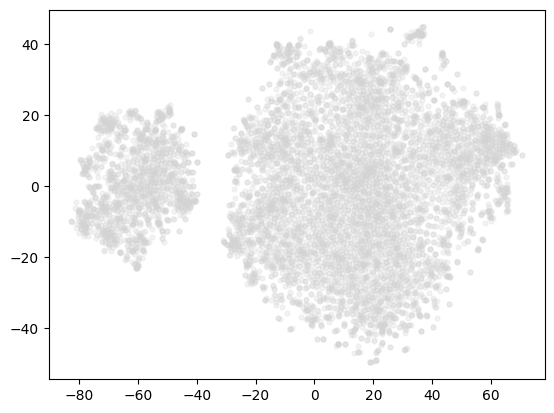

In [7]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c="lightgrey", alpha=0.25, s=12);

### HDBSCAN Parameters

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html#

- `min_cluster_size` should be set to the smallest size grouping one wish to consider a cluster.

- `min_samples` if unspecified follows `min_cluster_size`, but if set it essentially provide a measure of how conservative one want the clustering to be.

- `cluster_selection_epsilon` is nice because it allows me to set a small `min_cluster_size` becasue groups of few points are important. The param sets a threshold so that clusters below it are not split up any further.

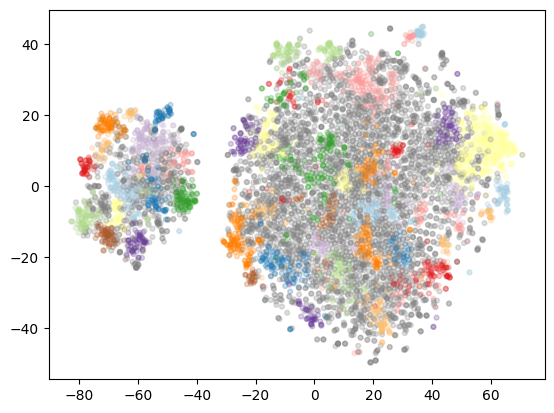

In [38]:
import hdbscan
import seaborn as sns

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30, 
    min_samples=1,
    cluster_selection_epsilon=0.16,
    max_cluster_size=250,
).fit(embeddings_umap)

color_palette = sns.color_palette("Paired", n_colors=len(set(clusterer.labels_))) 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_member_colors, alpha=0.25, s=12);

In [39]:
import plotly.express as px

fig = px.scatter(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    color=clusterer.labels_.astype(str),
)

fig.show()

In [40]:
unique, counts = np.unique(clusterer.labels_, return_counts=True)
cluster_counts = dict(zip(unique, counts))

print(f"\nTotal number of points: {len(clusterer.labels_)}")
print(f"Number of clusters: {len([c for c in unique if c != -1])}")
print(f"Number of noise points (cluster -1): {cluster_counts.get(-1, 0)}")
print(f"Percentage of noise: {cluster_counts.get(-1, 0) / len(clusterer.labels_) * 100:.2f}%")
print(f"\n{'Cluster':<10} {'Count':<10} {'Percentage':<12}")

for cluster_id in sorted(unique):
    count = cluster_counts[cluster_id]
    percentage = count / len(clusterer.labels_) * 100
    cluster_label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"{cluster_label:<10} {count:<10} {percentage:>6.2f}%")

if len([c for c in unique if c != -1]) > 0:
    non_noise_counts = [cluster_counts[c] for c in unique if c != -1]
    print(f"\nCluster size statistics (excluding noise):")
    print(f"  Min size: {min(non_noise_counts)}")
    print(f"  Max size: {max(non_noise_counts)}")
    print(f"  Mean size: {np.mean(non_noise_counts):.2f}")
    print(f"  Median size: {np.median(non_noise_counts):.2f}")


Total number of points: 7202
Number of clusters: 47
Number of noise points (cluster -1): 3644
Percentage of noise: 50.60%

Cluster    Count      Percentage  
Noise      3644        50.60%
Cluster 0  37           0.51%
Cluster 1  67           0.93%
Cluster 2  86           1.19%
Cluster 3  105          1.46%
Cluster 4  56           0.78%
Cluster 5  41           0.57%
Cluster 6  51           0.71%
Cluster 7  83           1.15%
Cluster 8  175          2.43%
Cluster 9  65           0.90%
Cluster 10 52           0.72%
Cluster 11 70           0.97%
Cluster 12 113          1.57%
Cluster 13 70           0.97%
Cluster 14 115          1.60%
Cluster 15 78           1.08%
Cluster 16 39           0.54%
Cluster 17 35           0.49%
Cluster 18 39           0.54%
Cluster 19 96           1.33%
Cluster 20 42           0.58%
Cluster 21 45           0.62%
Cluster 22 42           0.58%
Cluster 23 37           0.51%
Cluster 24 89           1.24%
Cluster 25 36           0.50%
Cluster 26 73           1.01%
C